In [1]:
import os

if "src" not in os.listdir():
    os.chdir("../../../")

from datetime import timedelta
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import keras.backend as K
from keras import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.optimizers import Adam

from src.lib.stock_dataset import read_stock_dataset
from src.lib.activations import negative_softmax
from src.lib.losses import negative_profit_loss, multi_negative_sharpe_ratio_loss

In [2]:
symbols = ["SPY", "SPXS", "SPXL"]
n_time_steps = 64
batch_size = 256
epochs = 10

In [3]:
dataset = read_stock_dataset(symbols, "oc_ret", n_time_steps)
train, valid, test = dataset.train_valid_test_split(timedelta(days=365), timedelta(days=365), scaled=True)
n_features = train.n_features
n_symbols = train.n_symbols
print(f"Loaded {len(train)} training, {len(valid)}, validation, and {len(test)} testing samples")
print(f"{n_features} features")
print(f"{n_symbols} targets")

Loaded 366687 training, 98309, validation, and 97921 testing samples
39 features
3 targets


In [4]:
def build_model():
    target_tensor = Input((n_symbols,))
    input_tensor = Input((n_time_steps, n_features))
    z = input_tensor
    lstm_out = LSTM(64)(z)

    z = Dropout(0.25)(lstm_out)
    z = Dense(64, activation="selu")(z)
    z = Dropout(0.1)(z)
    holdings = Dense(n_symbols, activation=negative_softmax, name="holdings")(z)
    
    z = Dropout(0.25)(lstm_out)
    z = Dense(64, activation="selu")(z)
    z = Dropout(0.1)(z)
    p_invest = Dense(1, activation="sigmoid", name="p_invest")(z)

    model = Model([input_tensor, target_tensor], [holdings, p_invest])

    sharpe_loss = multi_negative_sharpe_ratio_loss(target_tensor, holdings)
    model.add_loss(sharpe_loss)

    adj_holdings = holdings * p_invest
    neg_adj_profit = K.sum(negative_profit_loss(target_tensor, adj_holdings), axis=-1)

    model.add_loss(neg_adj_profit)

    model.compile(Adam(lr=0.001))

    pred_model = Model(input_tensor, adj_holdings)

    return model, pred_model

In [5]:
train_batchable_index = train.get_batchable_index()
n_iter_per_epoch = len(train_batchable_index)//batch_size

loss_history = []

model, pred_model = build_model()
valid_batchable_index = valid.get_batchable_index()
X_batch_valid, y_batch_valid = valid.get_batch(len(valid), valid_batchable_index, replace=False, shuffle=False)
for epoch in range(epochs):
    pbar = tqdm(range(n_iter_per_epoch))
    for i in pbar:
        X_batch, y_batch = train.get_batch(batch_size, train_batchable_index)
        loss = model.train_on_batch([X_batch, y_batch])
        loss_history.append(loss)

        if len(loss_history) > 150:
            avg_loss = np.mean(loss_history[-150:])
        else:
            avg_loss = np.mean(loss_history)
        
        pbar.set_description("sharpe=%.3f" % -avg_loss)
    
    
    losses_valid = model.evaluate([X_batch_valid, y_batch_valid])
    avg_loss_valid = np.mean(losses_valid)


    print("Valid Sharpe:", -avg_loss_valid)

  0%|          | 0/1432 [00:00<?, ?it/s]2021-09-13 16:30:17.319621: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-13 16:30:17.323402: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz
sharpe=0.048: 100%|██████████| 1432/1432 [00:47<00:00, 30.16it/s]


3073/3073 [==============================] - 5s 1ms/step - loss: nan
Valid Sharpe: nan


sharpe=0.114: 100%|██████████| 1432/1432 [00:47<00:00, 30.30it/s]


3073/3073 [==============================] - 4s 1ms/step - loss: nan
Valid Sharpe: nan


sharpe=0.066: 100%|██████████| 1432/1432 [00:46<00:00, 30.65it/s]


3073/3073 [==============================] - 4s 1ms/step - loss: nan
Valid Sharpe: nan


sharpe=0.089: 100%|██████████| 1432/1432 [00:46<00:00, 30.87it/s]


3073/3073 [==============================] - 4s 1ms/step - loss: nan
Valid Sharpe: nan


sharpe=0.069:  20%|██        | 293/1432 [00:10<00:40, 28.32it/s]


KeyboardInterrupt: 

In [7]:
X_batch_valid.shape

(98309, 64, 39)

SPY


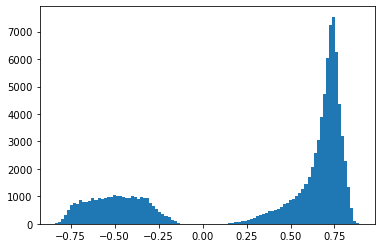

SPXS


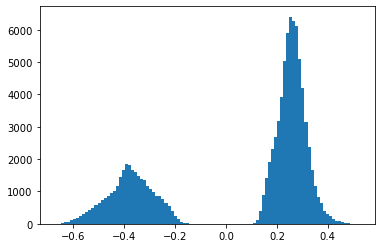

SPXL


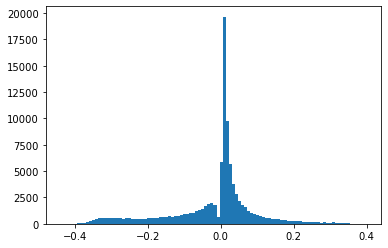

Allocation


KeyboardInterrupt: 

In [6]:
preds = pred_model.predict(X_batch_valid)
for i, ticker in enumerate(symbols):
    print(ticker)
    plt.hist(preds[:, i], bins=100)
    plt.show()

print("Allocation")
plt.hist(np.abs(preds).sum(-1), bins=100)
plt.show()

In [8]:
x = preds[:, 0]
y = preds[:, 1]

heatmap, xedges, yedges = np.histogram2d(x, y, bins=256)
# heatmap = np.log(heatmap+1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig = go.Figure()
fig.add_trace(go.Heatmap(z=heatmap.T))
fig.show()

In [ ]:
rets = np.exp((np.log(preds * y_batch_valid+1)).sum(axis=-1).cumsum())
fig = go.Figure()
fig.add_trace(go.Scatter(x=valid.index, y=rets))
fig.show()